# Non-Probabilistic Supervised Classification

In [138]:
# --- Imports ---
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.impute import SimpleImputer

# --- Models ---
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

from wittgenstein import RIPPER
from chefboost import Chefboost

In [139]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

train_df.drop(columns='Unnamed: 0', axis=1, inplace=True)
test_df.drop(columns='Unnamed: 0', axis=1, inplace=True)

print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nOriginal Training Set Shape: {train_df.shape} - {(train_df.shape[0]/(train_df.shape[0]+test_df.shape[0]))*100}%")
print(f"Original Test Set Shape: {test_df.shape} - {(test_df.shape[0]/(train_df.shape[0]+test_df.shape[0]))*100}%")

DATASET OVERVIEW

Original Training Set Shape: (103904, 24) - 80.0%
Original Test Set Shape: (25976, 24) - 20.0%


### 2.1 Exploratory Data Analysis

In [140]:
# Display basic information
print("\n" + "="*80)
print("DATASET INFORMATION")
print("="*80)
print("\nColumn Data Types:")
print(train_df.dtypes)

print("\n" + "="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)
missing_counts = train_df.isnull().sum()
missing_percent = (train_df.isnull().sum() / len(train_df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Percentage': missing_percent
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
print(missing_df)


DATASET INFORMATION

Column Data Types:
id                                     int64
Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure Dela

In [141]:
# Statistical summary
print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)
print(train_df.describe())


STATISTICAL SUMMARY
                  id            Age  Flight Distance  Inflight wifi service  \
count  103904.000000  103904.000000    103904.000000          103904.000000   
mean    64924.210502      39.379706      1189.448375               2.729683   
std     37463.812252      15.114964       997.147281               1.327829   
min         1.000000       7.000000        31.000000               0.000000   
25%     32533.750000      27.000000       414.000000               2.000000   
50%     64856.500000      40.000000       843.000000               3.000000   
75%     97368.250000      51.000000      1743.000000               4.000000   
max    129880.000000      85.000000      4983.000000               5.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                      103904.000000           103904.000000   
mean                            3.060296                2.756901   
std                             1.525075                1.39892

In [142]:
# Drop ID column if present
if 'id' in train_df.columns:
    train_df = train_df.drop(columns=['id'])

train_df = train_df.dropna(subset=['satisfaction'])  # ensure target is not missing
train_df = train_df.dropna(axis=0)  # drop any incomplete rows for simplicity

# --- Separate features and target ---
X = train_df.drop(columns=['satisfaction'])
y = train_df['satisfaction'].replace({'satisfied': 1, 'neutral or dissatisfied': 0})

C:\Users\Pedro\AppData\Local\Temp\ipykernel_24176\1236862820.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = train_df['satisfaction'].replace({'satisfied': 1, 'neutral or dissatisfied': 0})


In [143]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# --- Define preprocessing for each feature type ---
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [144]:
models = {
    # Existing models
    "k-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Artificial Neural Network": MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42),
    "Support Vector Machine (Linear)": LinearSVC(C=1, max_iter=5000, random_state=42),
    # "Support Vector Machine (Non-Linear RBF)": SVC(kernel='rbf', C=1, gamma='scale', random_state=42),
    
    # Classification Trees
    "Classification Tree (ID3 - Entropy)": DecisionTreeClassifier(criterion='entropy', random_state=42),
    
    # Rule-based
    "Rule Induction (RIPPER)": RIPPER(k=2, max_rules=20, random_state=42),
    
    # Optional: C4.5 equivalent (via Chefboost)
    # Warning: Chefboost doesn’t integrate seamlessly with scikit-learn pipelines or cross_validate,
    # but can be run separately if you want to demonstrate its inclusion in Results.
}

In [145]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [146]:
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    if name == "Rule Induction (RIPPER)":
        # Encode categorical manually
        X_encoded = pd.get_dummies(X, drop_first=True)
        
        # Manual cross-validation for RIPPER
        fold_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
        for train_idx, val_idx in cv.split(X_encoded, y):
            model.fit(X_encoded.iloc[train_idx], y.iloc[train_idx])
            preds = model.predict(X_encoded.iloc[val_idx])
            
            fold_scores['accuracy'].append(accuracy_score(y.iloc[val_idx], preds))
            fold_scores['precision'].append(precision_score(y.iloc[val_idx], preds))
            fold_scores['recall'].append(recall_score(y.iloc[val_idx], preds))
            fold_scores['f1'].append(f1_score(y.iloc[val_idx], preds))
        
        results[name] = {f'test_{metric}': np.mean(scores) for metric, scores in fold_scores.items()}
        continue

    # Normal models (with pipeline)
    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('model', model)
    ])
    
    cv_results = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    results[name] = {metric: np.mean(scores) for metric, scores in cv_results.items() if 'test_' in metric}


Training k-Nearest Neighbors...
Training Artificial Neural Network...
Training Support Vector Machine (Linear)...
Training Classification Tree (ID3 - Entropy)...
Training Rule Induction (RIPPER)...


In [147]:
results_df = pd.DataFrame(results).T
results_df.columns = [col.replace('test_', '') for col in results_df.columns]
results_df = results_df.sort_values(by='f1', ascending=False)

print("=== Cross-Validated Performance (All Original Variables) ===")
display(results_df.round(4))

=== Cross-Validated Performance (All Original Variables) ===


,accuracy,precision,recall,f1
Artificial Neural Network,0.9578,0.9642,0.9375,0.9506
Classification Tree (ID3 - Entropy),0.9477,0.9379,0.9417,0.9398
k-Nearest Neighbors,0.9275,0.9443,0.8849,0.9136
Rule Induction (RIPPER),0.8998,0.9829,0.7825,0.8712
Support Vector Machine (Linear),0.8745,0.8711,0.8340,0.8521


## (2) Univariate Filter Feature Subset Selection

In this section, we perform univariate feature selection — i.e., we evaluate each feature
individually according to its relationship with the target variable.

We use mutual information (model-free criterion) to select the most informative features,
which is suitable for both categorical and continuous variables.

The same set of classifiers will be evaluated after feature reduction.

In [148]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# --- Features to select ---
k_best = 15

# --- Feature selection transformer ---
univariate_selector = SelectKBest(score_func=mutual_info_classif, k=k_best)

# --- Extend preprocessing pipeline ---
# The feature selector is applied *after* preprocessing (so we work on numeric arrays)
models_univariate = models.copy()
results_univariate = {}

for name, model in models_univariate.items():

    if name == "Rule Induction (RIPPER)":
        # Preprocess and encode data
        X_preprocessed = preprocessor.fit_transform(X)
        
        # Apply univariate feature selection
        X_selected = univariate_selector.fit_transform(X_preprocessed, y)
        X_selected_df = pd.DataFrame(X_selected)
        
        # Manual cross-validation for RIPPER
        fold_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
        for train_idx, val_idx in cv.split(X_selected_df, y):
            model.fit(X_selected_df.iloc[train_idx], y.iloc[train_idx])
            preds = model.predict(X_selected_df.iloc[val_idx])
            
            fold_scores['accuracy'].append(accuracy_score(y.iloc[val_idx], preds))
            fold_scores['precision'].append(precision_score(y.iloc[val_idx], preds))
            fold_scores['recall'].append(recall_score(y.iloc[val_idx], preds))
            fold_scores['f1'].append(f1_score(y.iloc[val_idx], preds))
        
        results_univariate[name] = {f'test_{metric}': np.mean(scores) for metric, scores in fold_scores.items()}
        continue
    
    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('select', univariate_selector),
        ('model', model)
    ])
    
    cv_results = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    results_univariate[name] = {metric: np.mean(scores) for metric, scores in cv_results.items() if 'test_' in metric}


In [149]:
# --- Summarize results ---
results_uni_df = pd.DataFrame(results_univariate).T
results_uni_df.columns = [col.replace('test_', '') for col in results_uni_df.columns]
results_uni_df = results_uni_df.sort_values(by='f1', ascending=False)

print("=== Cross-Validated Performance (Univariate Feature Selection) ===")
display(results_uni_df.round(4))

=== Cross-Validated Performance (Univariate Feature Selection) ===


,accuracy,precision,recall,f1
Artificial Neural Network,0.9471,0.9515,0.9253,0.9382
Classification Tree (ID3 - Entropy),0.9306,0.9194,0.9207,0.9200
k-Nearest Neighbors,0.9314,0.9389,0.9003,0.9192
Support Vector Machine (Linear),0.8553,0.8416,0.8205,0.8309
Rule Induction (RIPPER),0.8619,0.9398,0.7309,0.8186


In [150]:
# --- Optional: Compare with baseline (all features) ---
comparison_df = results_df[['accuracy', 'f1']].join(
    results_uni_df[['accuracy', 'f1']],
    lsuffix='_original', rsuffix='_univariate'
)
print("=== Comparison: All Variables vs. Univariate Feature Selection ===")
display(comparison_df.round(4))

=== Comparison: All Variables vs. Univariate Feature Selection ===


,accuracy_original,f1_original,accuracy_univariate,f1_univariate
Artificial Neural Network,0.9578,0.9506,0.9471,0.9382
Classification Tree (ID3 - Entropy),0.9477,0.9398,0.9306,0.9200
k-Nearest Neighbors,0.9275,0.9136,0.9314,0.9192
Rule Induction (RIPPER),0.8998,0.8712,0.8619,0.8186
Support Vector Machine (Linear),0.8745,0.8521,0.8553,0.8309


## (3) Multivariate Filter Feature Subset Selection

While univariate filters consider each variable independently, multivariate filters
evaluate relationships *between* features — aiming to remove redundancy among predictors.

We will apply a correlation-based filter to remove highly correlated numerical features.

For categorical variables, we will keep all dummy-encoded features since their correlations
are typically handled by the encoder. The filtered set will then be used for model evaluation.


In [151]:
# --- Copy the original dataset before preprocessing ---
X_filtered = X.copy()

# --- Compute correlation matrix for numerical variables ---
corr_matrix = X_filtered[numerical_cols].corr().abs()

# --- Identify and remove highly correlated features ---
threshold = 0.85  # threshold for multicollinearity
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

print(f"Number of numerical features before filtering: {len(numerical_cols)}")
print(f"Number of numerical features to drop (|r| > {threshold}): {len(to_drop)}")
print("Dropped features:", to_drop)

# --- Update the list of numerical columns ---
numerical_cols_filtered = [col for col in numerical_cols if col not in to_drop]

# --- Redefine preprocessing with the reduced numerical subset ---
numeric_transformer_filtered = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor_multivariate = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_filtered, numerical_cols_filtered),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

Number of numerical features before filtering: 18
Number of numerical features to drop (|r| > 0.85): 1
Dropped features: ['Arrival Delay in Minutes']


In [152]:
results_multivariate = {}

for name, model in models.items():

    if name == "Rule Induction (RIPPER)":
        # Use filtered numerical columns + all categorical columns
        X_filtered_ripper = X_filtered.copy()
        X_encoded = pd.get_dummies(X_filtered_ripper, drop_first=True)
        
        # Manual cross-validation for RIPPER
        fold_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
        for train_idx, val_idx in cv.split(X_encoded, y):
            model.fit(X_encoded.iloc[train_idx], y.iloc[train_idx])
            preds = model.predict(X_encoded.iloc[val_idx])
            
            fold_scores['accuracy'].append(accuracy_score(y.iloc[val_idx], preds))
            fold_scores['precision'].append(precision_score(y.iloc[val_idx], preds))
            fold_scores['recall'].append(recall_score(y.iloc[val_idx], preds))
            fold_scores['f1'].append(f1_score(y.iloc[val_idx], preds))
        
        results_multivariate[name] = {f'test_{metric}': np.mean(scores) for metric, scores in fold_scores.items()}
        continue

    pipe = Pipeline([
        ('preprocess', preprocessor_multivariate),
        ('model', model)
    ])
    
    cv_results = cross_validate(pipe, X_filtered, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    results_multivariate[name] = {metric: np.mean(scores) for metric, scores in cv_results.items() if 'test_' in metric}

# %%
results_multi_df = pd.DataFrame(results_multivariate).T
results_multi_df.columns = [col.replace('test_', '') for col in results_multi_df.columns]
results_multi_df = results_multi_df.sort_values(by='f1', ascending=False)

print("=== Cross-Validated Performance (Multivariate Feature Selection) ===")
display(results_multi_df.round(4))

=== Cross-Validated Performance (Multivariate Feature Selection) ===


,accuracy,precision,recall,f1
Artificial Neural Network,0.9588,0.9640,0.9401,0.9518
Classification Tree (ID3 - Entropy),0.9479,0.9392,0.9407,0.9399
k-Nearest Neighbors,0.9275,0.9452,0.8840,0.9136
Rule Induction (RIPPER),0.8998,0.9829,0.7825,0.8712
Support Vector Machine (Linear),0.8742,0.8706,0.8337,0.8518


In [153]:
# --- Optional: Global comparison across all methods ---
comparison_full = pd.concat(
    [
        results_df[['accuracy', 'f1']],
        results_uni_df[['accuracy', 'f1']],
        results_multi_df[['accuracy', 'f1']]
    ],
    axis=1,
    keys=['original', 'univariate', 'multivariate']
)
# Flatten column names
comparison_full.columns = [f'{col}_{key}' for key, col in comparison_full.columns]

print("=== Comparison: Original vs. Univariate vs. Multivariate Selection ===")
display(comparison_full.round(4))

=== Comparison: Original vs. Univariate vs. Multivariate Selection ===


,accuracy_original,f1_original,accuracy_univariate,f1_univariate,accuracy_multivariate,f1_multivariate
Artificial Neural Network,0.9578,0.9506,0.9471,0.9382,0.9588,0.9518
Classification Tree (ID3 - Entropy),0.9477,0.9398,0.9306,0.9200,0.9479,0.9399
k-Nearest Neighbors,0.9275,0.9136,0.9314,0.9192,0.9275,0.9136
Rule Induction (RIPPER),0.8998,0.8712,0.8619,0.8186,0.8998,0.8712
Support Vector Machine (Linear),0.8745,0.8521,0.8553,0.8309,0.8742,0.8518


## (4) Wrapper Feature Subset Selection

Wrapper methods search for an optimal subset of features by evaluating subsets directly
using a predictive model. Here, we use Recursive Feature Elimination with Cross-Validation (RFECV)
to iteratively prune the least important features and retain those that maximize performance.

In [154]:
from sklearn.feature_selection import RFECV

# --- We'll use a smaller CV for RFE to reduce computation ---
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# We'll select a representative model for the wrapper — SVM or Decision Tree are typical.
# Using a tree model (e.g., DecisionTreeClassifier) makes feature importance extraction efficient.
base_estimator = DecisionTreeClassifier(criterion='entropy', random_state=42)

In [155]:
# --- Build a preprocessing pipeline without model yet ---
preprocessor_wrapper = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# --- Prepare preprocessed feature matrix for RFE (we must fully transform it once) ---
X_preprocessed = preprocessor_wrapper.fit_transform(X)
feature_names = (
    list(numerical_cols) +
    list(preprocessor_wrapper.named_transformers_['cat']
         .named_steps['encoder'].get_feature_names_out(categorical_cols))
)

In [156]:
# --- RFECV: recursive feature elimination with internal cross-validation ---
rfecv = RFECV(
    estimator=base_estimator,
    step=1,
    cv=inner_cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
rfecv.fit(X_preprocessed, y)

print(f"Optimal number of features: {rfecv.n_features_}")
selected_features = np.array(feature_names)[rfecv.support_]
print("Selected features:")
print(selected_features)

Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Optimal number of features: 16
Selected features:
['Age' 'Flight Distance' 'Inflight wifi service' 'Gate location'
 'Online boarding' 'Seat comfort' 'Inflight entertainment'
 'Leg room service' 'Baggage handling' 'Checkin service'
 'Inflight service' 'Arrival Delay in Minutes'
 'Customer Type_Loyal Customer' 'Customer Type_disloyal Customer'
 'Type of Travel_Business travel' 'Class_Business']


In [157]:
# --- Apply selected features to the full dataset ---
X_wrapper = pd.DataFrame(X_preprocessed, columns=feature_names)
X_wrapper = X_wrapper[selected_features]

In [158]:
# --- Evaluate all classifiers again using the wrapper-selected feature subset ---
results_wrapper = {}

for name, model in models.items():

    if name == "Rule Induction (RIPPER)":
        # X_wrapper is already preprocessed and feature-selected
        # Just ensure it's a proper DataFrame
        X_wrapper_ripper = pd.DataFrame(X_wrapper, columns=selected_features)
        
        # Manual cross-validation for RIPPER
        fold_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
        for train_idx, val_idx in cv.split(X_wrapper_ripper, y):
            model.fit(X_wrapper_ripper.iloc[train_idx], y.iloc[train_idx])
            preds = model.predict(X_wrapper_ripper.iloc[val_idx])
            
            fold_scores['accuracy'].append(accuracy_score(y.iloc[val_idx], preds))
            fold_scores['precision'].append(precision_score(y.iloc[val_idx], preds))
            fold_scores['recall'].append(recall_score(y.iloc[val_idx], preds))
            fold_scores['f1'].append(f1_score(y.iloc[val_idx], preds))
        
        results_wrapper[name] = {f'test_{metric}': np.mean(scores) for metric, scores in fold_scores.items()}
        continue
    
    pipe = Pipeline([
        ('scaler', StandardScaler(with_mean=False)),  # data already encoded
        ('model', model)
    ])
    
    cv_results = cross_validate(pipe, X_wrapper, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    results_wrapper[name] = {metric: np.mean(scores) for metric, scores in cv_results.items() if 'test_' in metric}

In [159]:
results_wrapper_df = pd.DataFrame(results_wrapper).T
results_wrapper_df.columns = [col.replace('test_', '') for col in results_wrapper_df.columns]
results_wrapper_df = results_wrapper_df.sort_values(by='f1', ascending=False)

print("=== Cross-Validated Performance (Wrapper Feature Selection) ===")
display(results_wrapper_df.round(4))

=== Cross-Validated Performance (Wrapper Feature Selection) ===


,accuracy,precision,recall,f1
Artificial Neural Network,0.9592,0.9634,0.9416,0.9524
Classification Tree (ID3 - Entropy),0.9461,0.9365,0.9394,0.9379
k-Nearest Neighbors,0.9350,0.9564,0.8907,0.9224
Rule Induction (RIPPER),0.8961,0.9816,0.7752,0.8654
Support Vector Machine (Linear),0.8695,0.8612,0.8333,0.8470


In [160]:
# --- Final comparison of all feature selection strategies ---
comparison_all = (
    results_df[['accuracy', 'f1']].rename(columns={'accuracy': 'accuracy_original', 'f1': 'f1_original'})
    .join(results_uni_df[['accuracy', 'f1']].rename(columns={'accuracy': 'accuracy_univariate', 'f1': 'f1_univariate'}))
    .join(results_multi_df[['accuracy', 'f1']].rename(columns={'accuracy': 'accuracy_multivariate', 'f1': 'f1_multivariate'}))
    .join(results_wrapper_df[['accuracy', 'f1']].rename(columns={'accuracy': 'accuracy_wrapper', 'f1': 'f1_wrapper'}))
)

print("=== Comprehensive Comparison: Original vs. Univariate vs. Multivariate vs. Wrapper ===")
display(comparison_all.round(4))

=== Comprehensive Comparison: Original vs. Univariate vs. Multivariate vs. Wrapper ===


,accuracy_original,f1_original,accuracy_univariate,f1_univariate,accuracy_multivariate,f1_multivariate,accuracy_wrapper,f1_wrapper
Artificial Neural Network,0.9578,0.9506,0.9471,0.9382,0.9588,0.9518,0.9592,0.9524
Classification Tree (ID3 - Entropy),0.9477,0.9398,0.9306,0.9200,0.9479,0.9399,0.9461,0.9379
k-Nearest Neighbors,0.9275,0.9136,0.9314,0.9192,0.9275,0.9136,0.9350,0.9224
Rule Induction (RIPPER),0.8998,0.8712,0.8619,0.8186,0.8998,0.8712,0.8961,0.8654
Support Vector Machine (Linear),0.8745,0.8521,0.8553,0.8309,0.8742,0.8518,0.8695,0.8470


## Interpretability Visualizations (Wrapper Feature Selection)

We'll add three high-value plots:
1. F1-score vs. Number of Selected Features (from RFECV)
2. Top 15 Most Important Features (Decision Tree importances)
3. Comparative bar plot of mean F1-scores across all feature selection strategies

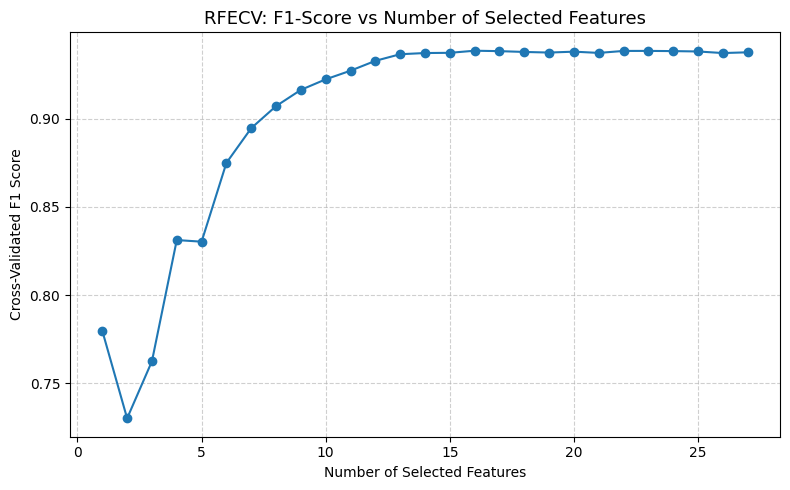

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1️⃣ F1-score vs. number of selected features ---
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"], marker='o', color='tab:blue')
plt.title("RFECV: F1-Score vs Number of Selected Features", fontsize=13)
plt.xlabel("Number of Selected Features")
plt.ylabel("Cross-Validated F1 Score")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

C:\Users\Pedro\AppData\Local\Temp\ipykernel_24176\950832265.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette='viridis')


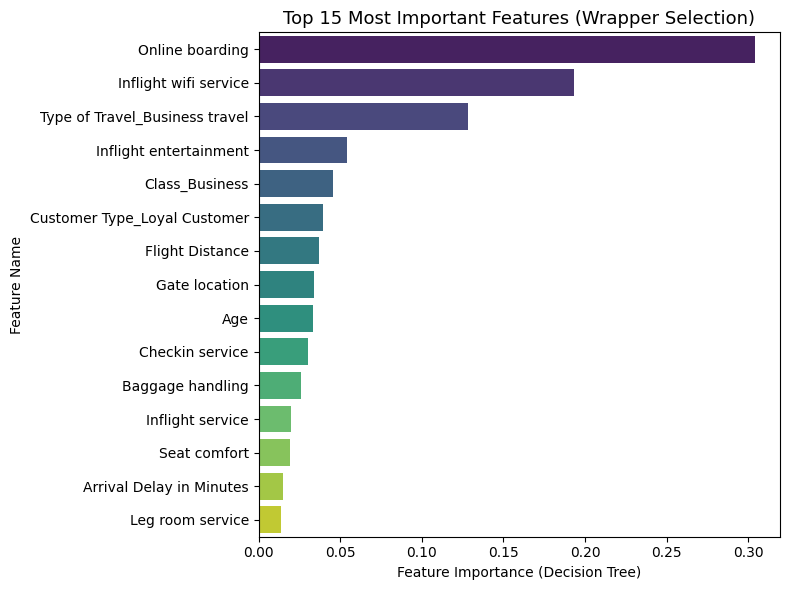

In [162]:
# --- 2️⃣ Feature importance bar plot (top 15 features) ---
importances = rfecv.estimator_.feature_importances_

# Selected feature names (already in correct order)
selected_feature_names = np.array(selected_features)

# Sort and visualize top 15
top_features_idx = np.argsort(importances)[::-1][:15]
top_features = selected_feature_names[top_features_idx]
top_importances = importances[top_features_idx]

plt.figure(figsize=(8, 6))
sns.barplot(x=top_importances, y=top_features, palette='viridis')
plt.title("Top 15 Most Important Features (Wrapper Selection)", fontsize=13)
plt.xlabel("Feature Importance (Decision Tree)")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()

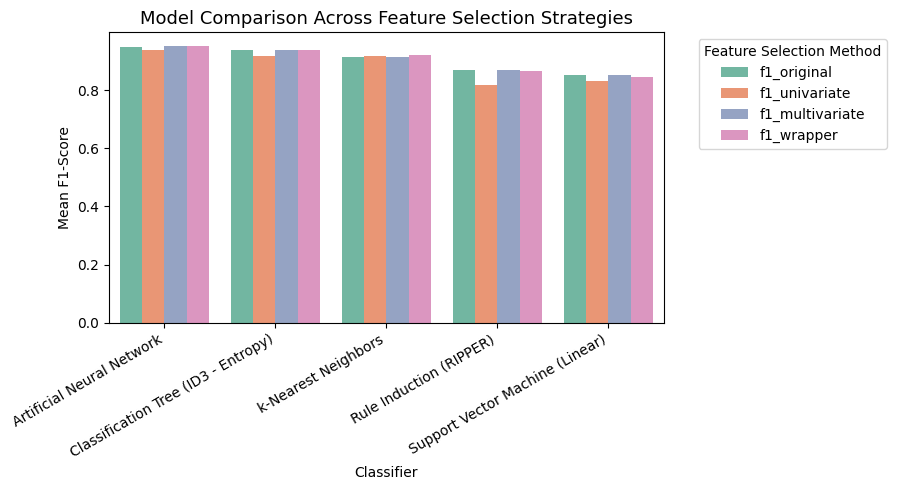

In [ ]:
# --- 3️⃣ Comparative visualization of F1-scores across feature selection methods ---
comparison_melted = comparison_all[['f1_original', 'f1_univariate', 'f1_multivariate', 'f1_wrapper']].reset_index().melt(
    id_vars='index', var_name='Method', value_name='F1-Score'
)

plt.figure(figsize=(9, 5))
sns.barplot(
    data=comparison_melted,
    x='index', y='F1-Score', hue='Method', palette='Set2'
)
plt.title("Model Comparison Across Feature Selection Strategies", fontsize=13)
plt.xlabel("Classifier")
plt.ylabel("Mean F1-Score")
plt.xticks(rotation=30, ha='right')
plt.legend(title='Feature Selection Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()